In [ ]:
# perlu instal pertama kali menggunakan library ini di positron

# pip install tabulate
# !python3 -m pip install umap-learn
# pip install sentence_transformers


## buka library yang diperlukan

In [2]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch
import re

## persiapkan data

In [3]:
# Contoh aplikasi ke DataFrame
df = pd.read_pickle("dataarticle.pkl")
df['textdata'] = df['textdata'].str.lower()

## Semantic Similarity (20 file 1m 7s) untuk artikel umum

In [4]:
# Load model ringan
model = SentenceTransformer('all-MiniLM-L6-v2')

# Anchor naratif

capitalism_anchor = (
    "The Capitalism/Profit Focus paradigm is centrally built on maximizing financial or market performance, seeking competitive advantage, and prioritizing firm profitability, often driven by the tenets of shareholder theory, which posits that investments not directly aimed at economic results may exacerbate company performance. This traditional model assumes organizational members are self-interested utility maximisers who often focus on short-term gains, leading to behaviors like exploitation and contributing to considerable economic and social inequalities."
)

welfare_anchor = (
    "The Common Welfare/Sustainability Focus, framed as corporate sustainability, emphasizes the integration of the Triple Bottom Line (TBL) to achieve collective well-being and long-term corporate survival by managing stakeholder concerns. This approach aims for development that meets the needs of the present without compromising future generations and requires fostering prosocial behavior and leveraging knowledge management to enhance organizational resilience."
)

# Encode anchor
capitalism_vec = model.encode(capitalism_anchor, convert_to_tensor=True)
welfare_vec = model.encode(welfare_anchor, convert_to_tensor=True)

# Pemecah kalimat ringan (tanpa NLTK)
def simple_sentence_split(text):
    return re.split(r'(?<=[.!?])\s+', text.strip())

# Fungsi utama
def semantic_similarity_chunked(text, chunk_size=5):
    if not text or not isinstance(text, str):
        return 0.0, 0.0

    sentences = simple_sentence_split(text)
    chunks = [' '.join(sentences[i:i+chunk_size]) for i in range(0, len(sentences), chunk_size)]

    scores_c = []
    scores_w = []

    for chunk in chunks:
        vec = model.encode(chunk, convert_to_tensor=True)
        scores_c.append(util.cos_sim(vec, capitalism_vec).item())
        scores_w.append(util.cos_sim(vec, welfare_vec).item())

    avg_c = sum(scores_c) / len(scores_c) if scores_c else 0.0
    avg_w = sum(scores_w) / len(scores_w) if scores_w else 0.0

    return avg_c, avg_w

# Aplikasi ke DataFrame
df[['Sim_Capitalism', 'Sim_Welfare']] = df['textdata'].apply(
    lambda x: pd.Series(semantic_similarity_chunked(x))
)

# Tampilkan hasil
semantic_result = df[['articlename', 'Sim_Capitalism', 'Sim_Welfare']].sort_values(by='articlename', ascending=False)
print("\n--- HASIL SEMANTIC SIMILARITY (CHUNKED) ---")
print(semantic_result.to_markdown(index=False))



--- HASIL SEMANTIC SIMILARITY (CHUNKED) ---
| articlename      |   Sim_Capitalism |   Sim_Welfare |
|:-----------------|-----------------:|--------------:|
| ejmbe 07.pdf     |        0.304183  |     0.308843  |
| cemj 2022.pdf    |        0.166502  |     0.18518   |
| IMIC other.pdf   |        0.157851  |     0.163246  |
| IJOIS 2024.pdf   |        0.237221  |     0.193576  |
| IJOIMDI 2024.pdf |        0.18832   |     0.170539  |
| IJIEM 372.pdf    |        0.156998  |     0.124853  |
| IAGD 2024.pdf    |        0.246063  |     0.297559  |
| HASSC 2023.pdf   |        0.155269  |     0.214685  |
| EROMABE 2023.pdf |        0.314557  |     0.250216  |
| EBER 13.pdf      |        0.275591  |     0.18605   |
| DSAM 2024.pdf    |        0.0417867 |    -0.0126669 |
| DB 2022.pdf      |        0.124841  |     0.175028  |
| CLSC 2025.pdf    |        0.14658   |     0.321135  |
| CLSC  2023.pdf   |        0.255611  |     0.277434  |
| CJOAR 1 s2.pdf   |        0.166192  |     0.203061  |
| C

## uji beda

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

# nama kolom yang digunakan
col_a = "Sim_Capitalism"
col_b = "Sim_Welfare"

# Ambil pasangan nilai yang tidak NA pada kedua kolom (paired)
paired = df[[col_a, col_b]].dropna()

# Ringkasan statistik deskriptif untuk tiap kolom (pada seluruh DF dan pada pasangan)
print("Deskriptif (seluruh dataframe):")
print(df[[col_a, col_b]].describe().T[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]])
#print("\nDeskriptif (hanya untuk pasangan tanpa NA):")
#print(paired.describe().T[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]])

# Jika tidak ada pasangan yang cukup, hentikan
n_pairs = len(paired)
if n_pairs < 2:
    raise ValueError(f"Tidak cukup pasangan observasi untuk uji t (pasangan = {n_pairs}).")

# Uji T berpasangan pada pasangan yang valid
t_stat, p_value = ttest_rel(paired[col_a], paired[col_b])

print("\n--- UJI T BERPASANGAN ---")
print(f"Jumlah pasangan valid: {n_pairs}")
print(f"Statistik t: {t_stat:.4f}")
print(f"Nilai p: {p_value:.4f}")

# Interpretasi sederhana
alpha = 0.05
if p_value < alpha:
    print("✅ Terdapat perbedaan signifikan antara rata-rata kedua kolom (p < 0.05).")
else:
    print("⚠️ Tidak terdapat perbedaan signifikan antara rata-rata kedua kolom (p >= 0.05).")

# (Opsional) tampilkan selisih rata-rata dan ukuran efek sederhana (Cohen's d for paired samples)
diff = paired[col_a] - paired[col_b]
mean_diff = diff.mean()
sd_diff = diff.std(ddof=1)
cohens_d = mean_diff / sd_diff if sd_diff != 0 else np.nan

print("\nRingkasan Perbedaan:")
print(f"Rata-rata {col_a}: {paired[col_a].mean():.4f}")
print(f"Rata-rata {col_b}: {paired[col_b].mean():.4f}")
print(f"Rata-rata selisih ({col_a} - {col_b}): {mean_diff:.4f}")
print(f"SD selisih: {sd_diff:.4f}")
print(f"Cohen's d (paired): {cohens_d:.4f}")


Deskriptif (seluruh dataframe):
                count      mean       std       min       25%       50%  \
Sim_Capitalism   20.0  0.191461  0.071182  0.041787  0.153097  0.177411   
Sim_Welfare      20.0  0.200785  0.077365 -0.012667  0.173906  0.197388   

                     75%       max  
Sim_Capitalism  0.239431  0.314557  
Sim_Welfare     0.252559  0.321135  

--- UJI T BERPASANGAN ---
Jumlah pasangan valid: 20
Statistik t: -0.6780
Nilai p: 0.5060
⚠️ Tidak terdapat perbedaan signifikan antara rata-rata kedua kolom (p >= 0.05).

Ringkasan Perbedaan:
Rata-rata Sim_Capitalism: 0.1915
Rata-rata Sim_Welfare: 0.2008
Rata-rata selisih (Sim_Capitalism - Sim_Welfare): -0.0093
SD selisih: 0.0615
Cohen's d (paired): -0.1516


## Semantic Similarity (40 file 2m 28s) untuk artikel BSM

In [11]:
# Contoh aplikasi ke DataFrame
df = pd.read_pickle("dataarticleBSM.pkl")
df['textdata'] = df['textdata'].str.lower()

In [12]:
# Load model ringan
model = SentenceTransformer('all-MiniLM-L6-v2')

# Anchor naratif

capitalism_anchor = (
    "The Capitalism/Profit Focus paradigm is centrally built on maximizing financial or market performance, seeking competitive advantage, and prioritizing firm profitability, often driven by the tenets of shareholder theory, which posits that investments not directly aimed at economic results may exacerbate company performance. This traditional model assumes organizational members are self-interested utility maximisers who often focus on short-term gains, leading to behaviors like exploitation and contributing to considerable economic and social inequalities."
)

welfare_anchor = (
    "The Common Welfare/Sustainability Focus, framed as corporate sustainability, emphasizes the integration of the Triple Bottom Line (TBL) to achieve collective well-being and long-term corporate survival by managing stakeholder concerns. This approach aims for development that meets the needs of the present without compromising future generations and requires fostering prosocial behavior and leveraging knowledge management to enhance organizational resilience."
)

# Encode anchor
capitalism_vec = model.encode(capitalism_anchor, convert_to_tensor=True)
welfare_vec = model.encode(welfare_anchor, convert_to_tensor=True)

# Pemecah kalimat ringan (tanpa NLTK)
def simple_sentence_split(text):
    return re.split(r'(?<=[.!?])\s+', text.strip())

# Fungsi utama
def semantic_similarity_chunked(text, chunk_size=5):
    if not text or not isinstance(text, str):
        return 0.0, 0.0

    sentences = simple_sentence_split(text)
    chunks = [' '.join(sentences[i:i+chunk_size]) for i in range(0, len(sentences), chunk_size)]

    scores_c = []
    scores_w = []

    for chunk in chunks:
        vec = model.encode(chunk, convert_to_tensor=True)
        scores_c.append(util.cos_sim(vec, capitalism_vec).item())
        scores_w.append(util.cos_sim(vec, welfare_vec).item())

    avg_c = sum(scores_c) / len(scores_c) if scores_c else 0.0
    avg_w = sum(scores_w) / len(scores_w) if scores_w else 0.0

    return avg_c, avg_w

# Aplikasi ke DataFrame
df[['Sim_Capitalism', 'Sim_Welfare']] = df['textdata'].apply(
    lambda x: pd.Series(semantic_similarity_chunked(x))
)

# Tampilkan hasil
semantic_result = df[['articlename', 'Sim_Capitalism', 'Sim_Welfare']].sort_values(by='articlename', ascending=False)
print("\n--- HASIL SEMANTIC SIMILARITY (CHUNKED) ---")
print(semantic_result.to_markdown(index=False))


--- HASIL SEMANTIC SIMILARITY (CHUNKED) ---
| articlename                                   |   Sim_Capitalism |   Sim_Welfare |
|:----------------------------------------------|-----------------:|--------------:|
| 10-1108_tlo-11-2022-0135 Ziemak 2024.pdf      |         0.271295 |      0.349779 |
| 10-1108_techs-04-2023-0018 Araujo.pdf         |         0.260524 |      0.326531 |
| 10-1108_srj-01-2024-0009 Chong 2024.pdf       |         0.266725 |      0.380042 |
| 10-1108_scm-10-2023-0496 Bankel 2024.pdf      |         0.286976 |      0.285613 |
| 10-1108_scm-02-2024-0131 Esangbedo 2024.pdf   |         0.254692 |      0.331806 |
| 10-1108_scm-01-2023-0059 Sengupta 2023.pdf    |         0.239691 |      0.300084 |
| 10-1108_sbr-09-2023-0275 Sani.pdf             |         0.201507 |      0.373064 |
| 10-1108_sampj-09-2023-0701 Tommaso 2023.pdf   |         0.353844 |      0.369638 |
| 10-1108_sampj-04-2022-0168 Mendez 2024.pdf    |         0.254044 |      0.308117 |
| 10-1108_sampj-03-2

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

# nama kolom yang digunakan
col_a = "Sim_Capitalism"
col_b = "Sim_Welfare"

# Ambil pasangan nilai yang tidak NA pada kedua kolom (paired)
paired = df[[col_a, col_b]].dropna()

# Ringkasan statistik deskriptif untuk tiap kolom (pada seluruh DF dan pada pasangan)
print("Deskriptif (seluruh dataframe):")
print(df[[col_a, col_b]].describe().T[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]])
#print("\nDeskriptif (hanya untuk pasangan tanpa NA):")
#print(paired.describe().T[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]])

# Jika tidak ada pasangan yang cukup, hentikan
n_pairs = len(paired)
if n_pairs < 2:
    raise ValueError(f"Tidak cukup pasangan observasi untuk uji t (pasangan = {n_pairs}).")

# Uji T berpasangan pada pasangan yang valid
t_stat, p_value = ttest_rel(paired[col_a], paired[col_b])

print("\n--- UJI T BERPASANGAN ---")
print(f"Jumlah pasangan valid: {n_pairs}")
print(f"Statistik t: {t_stat:.4f}")
print(f"Nilai p: {p_value:.4f}")

# Interpretasi sederhana
alpha = 0.05
if p_value < alpha:
    print("✅ Terdapat perbedaan signifikan antara rata-rata kedua kolom (p < 0.05).")
else:
    print("⚠️ Tidak terdapat perbedaan signifikan antara rata-rata kedua kolom (p >= 0.05).")

# (Opsional) tampilkan selisih rata-rata dan ukuran efek sederhana (Cohen's d for paired samples)
diff = paired[col_a] - paired[col_b]
mean_diff = diff.mean()
sd_diff = diff.std(ddof=1)
cohens_d = mean_diff / sd_diff if sd_diff != 0 else np.nan

print("\nRingkasan Perbedaan:")
print(f"Rata-rata {col_a}: {paired[col_a].mean():.4f}")
print(f"Rata-rata {col_b}: {paired[col_b].mean():.4f}")
print(f"Rata-rata selisih ({col_a} - {col_b}): {mean_diff:.4f}")
print(f"SD selisih: {sd_diff:.4f}")
print(f"Cohen's d (paired): {cohens_d:.4f}")


Deskriptif (seluruh dataframe):
                count      mean       std       min       25%       50%  \
Sim_Capitalism   48.0  0.258954  0.034300  0.149991  0.243249  0.259950   
Sim_Welfare      48.0  0.315850  0.039507  0.238491  0.285442  0.309411   

                     75%       max  
Sim_Capitalism  0.277257  0.353844  
Sim_Welfare     0.350341  0.386884  

--- UJI T BERPASANGAN ---
Jumlah pasangan valid: 48
Statistik t: -9.3250
Nilai p: 0.0000
✅ Terdapat perbedaan signifikan antara rata-rata kedua kolom (p < 0.05).

Ringkasan Perbedaan:
Rata-rata Sim_Capitalism: 0.2590
Rata-rata Sim_Welfare: 0.3158
Rata-rata selisih (Sim_Capitalism - Sim_Welfare): -0.0569
SD selisih: 0.0423
Cohen's d (paired): -1.3459


## visual

In [14]:
# Generating heatmap for semantic similarity of articles to Capitalism and Welfare anchors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Transformasi ke format heatmap
heatmap_data = df.set_index('articlename')[['Sim_Capitalism', 'Sim_Welfare']].T

# Plot heatmap
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 4))
ax = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Semantic Similarity'})
ax.set_xlabel("Article Name")
ax.set_ylabel("Semantic Anchor")
ax.set_title("Semantic Similarity of Articles to Capitalism and Welfare Anchors")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Simpan plot
output_path = "semantic_similarity_heatmap.png"
plt.savefig(output_path)
plt.close()

print("Heatmap saved as 'semantic_similarity_heatmap.png'")


Heatmap saved as 'semantic_similarity_heatmap.png'


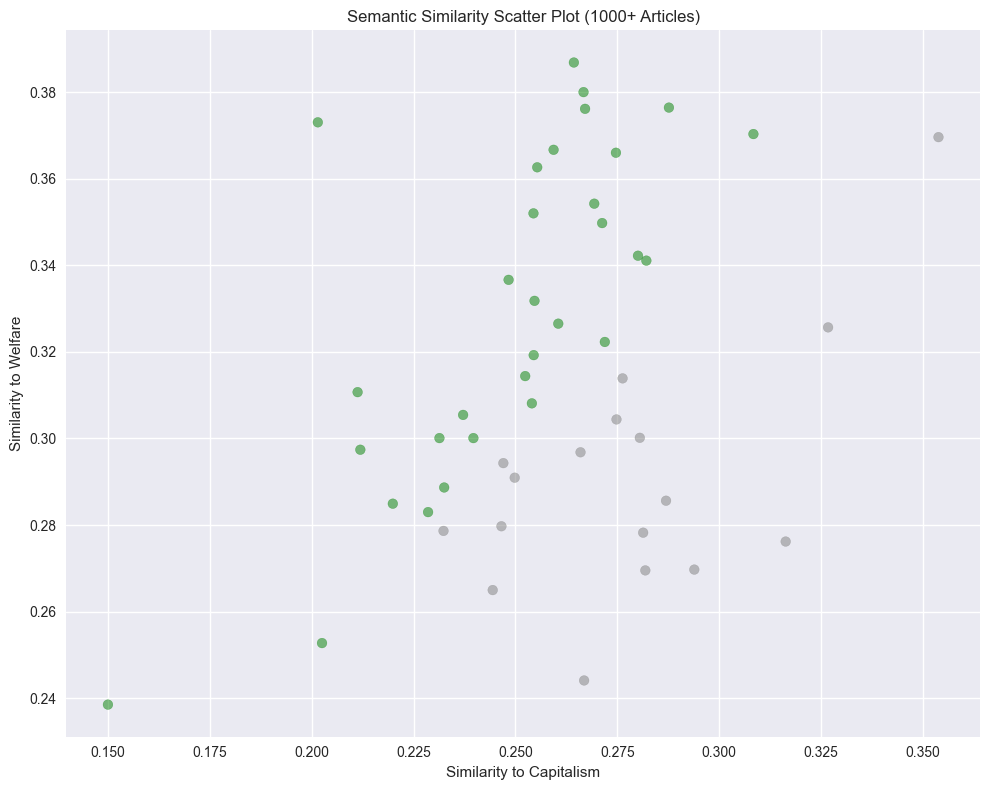

In [15]:
import matplotlib.pyplot as plt

# --- Pastikan kolom klasifikasi tersedia ---
def classify_ideology(row):
    diff = row['Sim_Capitalism'] - row['Sim_Welfare']
    if diff > 0.05:
        return 'Capitalist-Leaning'
    elif diff < -0.05:
        return 'Welfare-Leaning'
    else:
        return 'Neutral'

df['Ideology_Class'] = df.apply(classify_ideology, axis=1)

# --- Warna berdasarkan klasifikasi ---
colors = df['Ideology_Class'].map({
    'Capitalist-Leaning': 'blue',
    'Welfare-Leaning': 'green',
    'Neutral': 'gray'
})

# --- Scatter Plot ---
plt.figure(figsize=(10, 8))
plt.scatter(df['Sim_Capitalism'], df['Sim_Welfare'], c=colors, alpha=0.5)
plt.xlabel("Similarity to Capitalism")
plt.ylabel("Similarity to Welfare")
plt.title("Semantic Similarity Scatter Plot (1000+ Articles)")
plt.grid(True)
plt.tight_layout()
plt.show()


<positron-console-cell-16>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

<positron-console-cell-16>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



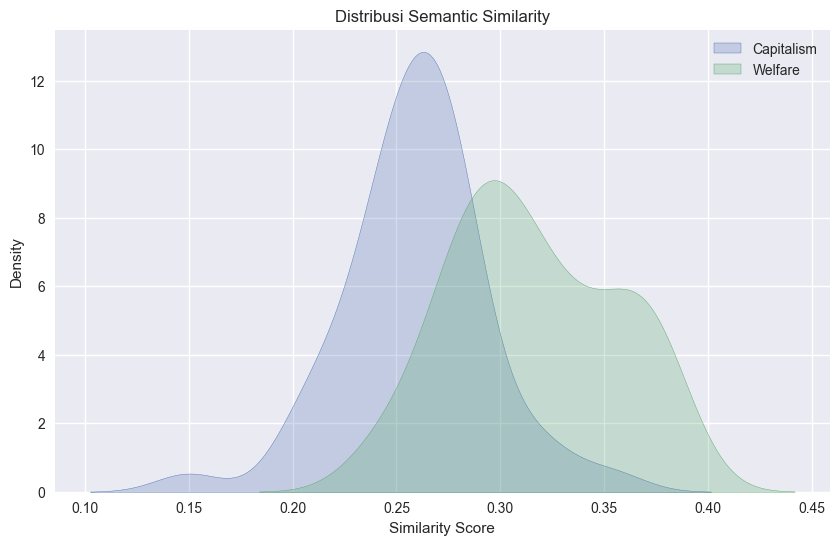

In [16]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Sim_Capitalism'], label='Capitalism', shade=True)
sns.kdeplot(df['Sim_Welfare'], label='Welfare', shade=True)
plt.title("Distribusi Semantic Similarity")
plt.xlabel("Similarity Score")
plt.legend()
plt.show()


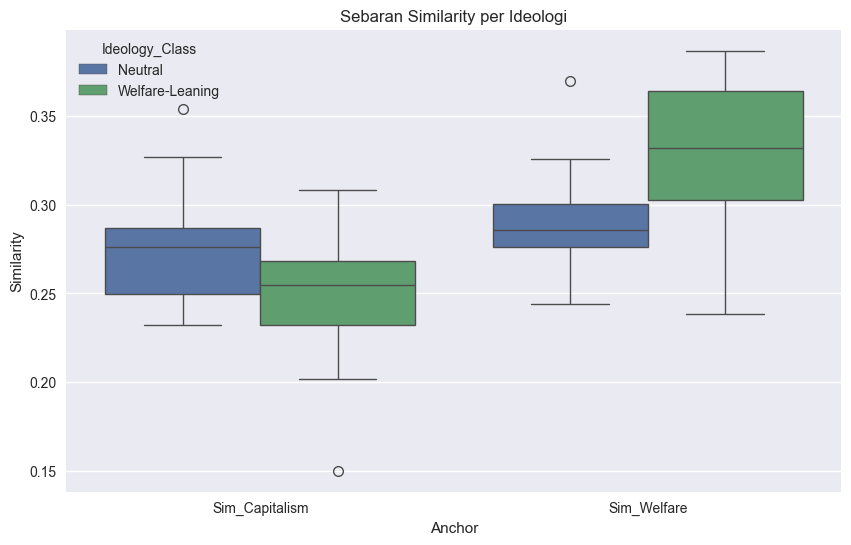

In [17]:
df_melted = df.melt(id_vars='Ideology_Class', value_vars=['Sim_Capitalism', 'Sim_Welfare'],
                    var_name='Anchor', value_name='Similarity')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Anchor', y='Similarity', hue='Ideology_Class', data=df_melted)
plt.title("Sebaran Similarity per Ideologi")
plt.show()
